## Temporal Graph Metrics and Macro Economics

This script computes key structural metrics for graphs, providing insights into their topology and node-level properties.

---

### Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Temporal Graph Metrics](#temporal-graph-metrics)
4. [Macro Economic Metrics](#macro-economic-metrics)

In [1]:
# General Utilities
import os
import warnings
from pathlib import Path

# Data Handling and Processing
import numpy as np
import pandas as pd

# Network Analysis
import networkx as nx
from community import community_louvain

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### Data Loading and Preparation

In [4]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

In [5]:
# Create dir for exporting plots
export_path = os.path.join("figures", hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

In [6]:
# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 49.6420 seconds


In [7]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [8]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [9]:
# Get aggregated export and import over all products
baseline_df = loader.get_baseline(load_precompute=True)

In [10]:
# Get Networkx representation of baseline_df
yearly_graphs = loader.get_yearly_graphs(years)

In [11]:
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [12]:
df

,t,i,j,k,v,q,export_country,import_country,description,iso3_o,...,tradeflow_imf_d,comlang_ethno,comcol,col45,comleg_pretrans,comleg_posttrans,col_dep_ever,empire,sibling_ever,scaled_sci_2021
0,2002,36,124,282520,7.627,2.211,Australia,Canada,Lithium oxide and hydroxide,AUS,...,1151881.5,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,19159.0
1,2002,36,360,282520,15.395,1.120,Australia,Indonesia,Lithium oxide and hydroxide,AUS,...,1814127.625,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,NaN
2,2002,36,372,282520,1.874,0.008,Australia,Ireland,Lithium oxide and hydroxide,AUS,...,109872.336,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,61908.0
3,2002,36,380,282520,2.748,0.003,Australia,Italy,Lithium oxide and hydroxide,AUS,...,1230163.625,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,7123.0
4,2002,36,554,282520,5.832,1.422,Australia,New Zealand,Lithium oxide and hydroxide,AUS,...,3335579.5,1.0,0.0,0.0,1.0,1.0,0.0,,1.0,247952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10856,2022,842,757,282520,94.439,1.124,United States of America,Switzerland,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10857,2022,842,764,282520,6188.819,89.237,United States of America,Thailand,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10858,2022,842,784,282520,2476.180,87.011,United States of America,United Arab Emirates,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
10859,2022,842,792,282520,0.873,0.045,United States of America,Turkey,Lithium oxide and hydroxide,None,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [13]:
baseline_df

,t,import_country,export_country,v
0,2001,Afghanistan,Australia,319.378
1,2001,Afghanistan,Austria,142.477
2,2001,Afghanistan,Azerbaijan,190.776
3,2001,Afghanistan,Bahrain,4.266
4,2001,Afghanistan,Bangladesh,6008.931
...,...,...,...,...
672029,2022,Zimbabwe,United Kingdom,85564.157
672030,2022,Zimbabwe,United Rep. of Tanzania,15260.089
672031,2022,Zimbabwe,Uruguay,220.626
672032,2022,Zimbabwe,Viet Nam,251.952


### Temporal Graph Metrics

In [29]:
def compute_diameter(G):
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.diameter(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        if G_sub.number_of_nodes() > 1:
            return nx.diameter(G_sub)
        else:
            return 0.0

def compute_degree_assortativity(G):
    if G.number_of_edges() > 0:
        return nx.degree_assortativity_coefficient(G, x='degree')
    else:
        return np.nan

def compute_avg_node_strength(G):
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = []
    for n in G.nodes():
        strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
        strengths.append(strength)
    if len(strengths) > 0:
        return np.mean(strengths)
    else:
        return np.nan

def gini_coefficient(values):
    arr = np.sort(values)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n+1 - 2*np.sum(rel_cumulative)/n)

def compute_gini_node_strength(G):
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = [sum(d['weight'] for _,_,d in G.edges(n, data=True)) for n in G.nodes()]
    if len(strengths) == 0:
        return np.nan
    return gini_coefficient(strengths)

def compute_fraction_bridges(G):
    if G.number_of_edges() == 0:
        return 0.0
    bridges = list(nx.bridges(G))
    return len(bridges) / G.number_of_edges()


In [30]:
results = {
    'year': [],
    'num_nodes': [],
    'num_edges': [],
    'density': [],
    'avg_clustering': [],
    'avg_shortest_path': [],
    'modularity': [],
    'num_communities': [],
    'diameter': [],
    'degree_assortativity': [],
    'avg_node_strength': [],
    'gini_node_strength': [],
    'fraction_bridges': [],
}

for y, G in yearly_graphs.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    density = nx.density(G)

    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)

    # Average shortest path length
    if nx.is_connected(G):
        avg_sp = nx.average_shortest_path_length(G, weight='inverse_weight')
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        avg_sp = nx.average_shortest_path_length(G_sub, weight='inverse_weight')

    # Community Detection
    partition = community_louvain.best_partition(G, weight='inverse_weight')
    mod = community_louvain.modularity(partition, G, weight='inverse_weight')
    num_com = len(set(partition.values()))

    # Diameter
    diameter = compute_diameter(G)

    # Degree Assortativity
    degree_assort = compute_degree_assortativity(G)

    # Average Node Strength
    avg_strength = compute_avg_node_strength(G)

    # Gini Coefficient of Node Strength
    gini_strength = compute_gini_node_strength(G)

    # Fraction Bridges
    frac_bridges = compute_fraction_bridges(G)

    results['year'].append(y)
    results['num_nodes'].append(num_nodes)
    results['num_edges'].append(num_edges)
    results['density'].append(density)
    results['avg_clustering'].append(avg_clustering)
    results['avg_shortest_path'].append(avg_sp)
    results['modularity'].append(mod)
    results['num_communities'].append(num_com)
    results['diameter'].append(diameter)
    results['degree_assortativity'].append(degree_assort)
    results['avg_node_strength'].append(avg_strength)
    results['gini_node_strength'].append(gini_strength)
    results['fraction_bridges'].append(frac_bridges)

results_df = pd.DataFrame(results)

In [31]:
def plot_metric(data, x_col, y_col, title, color="black", marker='o', figsize=(5, 4), degree=2):
    """
    Plots a metric with an optional polynomial trend line.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing the data.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        title (str): Title of the plot.
        color (str): Line color for the metric plot.
        marker (str): Marker style for the metric plot.
        figsize (tuple): Figure size (width, height).
        degree (int): Degree of the polynomial trend line (default is 2).
    """
    sns.set_theme(style="ticks")
    plt.rcParams.update({
        "font.family": "Arial",
        "mathtext.fontset": "stix",
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 12,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.8
    })

    plt.figure(figsize=figsize)

    sns.lineplot(data=data, x=x_col, y=y_col, marker=marker, color=color, linewidth=1.5, label='Metric')

    x = data[x_col].astype(float)
    y = data[y_col].astype(float)
    poly_coeffs = np.polyfit(x, y, degree)
    poly_func = np.poly1d(poly_coeffs)
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly_func(x_fit)

    plt.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=1.5, label=f'Polynomial Trend (Degree {degree})')

    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
    plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
    plt.xticks(data[x_col].unique().astype(int), rotation=90)
    plt.grid(visible=True, linestyle="--", linewidth=0.8, alpha=0.7)
    sns.despine()
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()

    filename = f"{hs_label}_{'_'.join(title.split()).lower()}.png"
    plt.savefig(os.path.join(export_path, filename), dpi=300, bbox_inches="tight", format="png")
    plt.show()

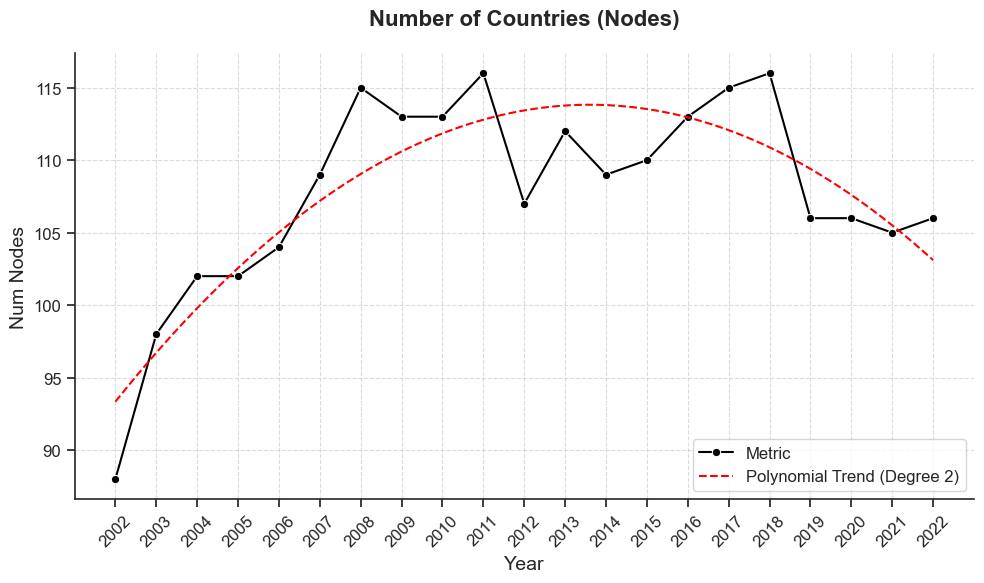

In [32]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_nodes',
    title="Number of Countries (Nodes)"
)

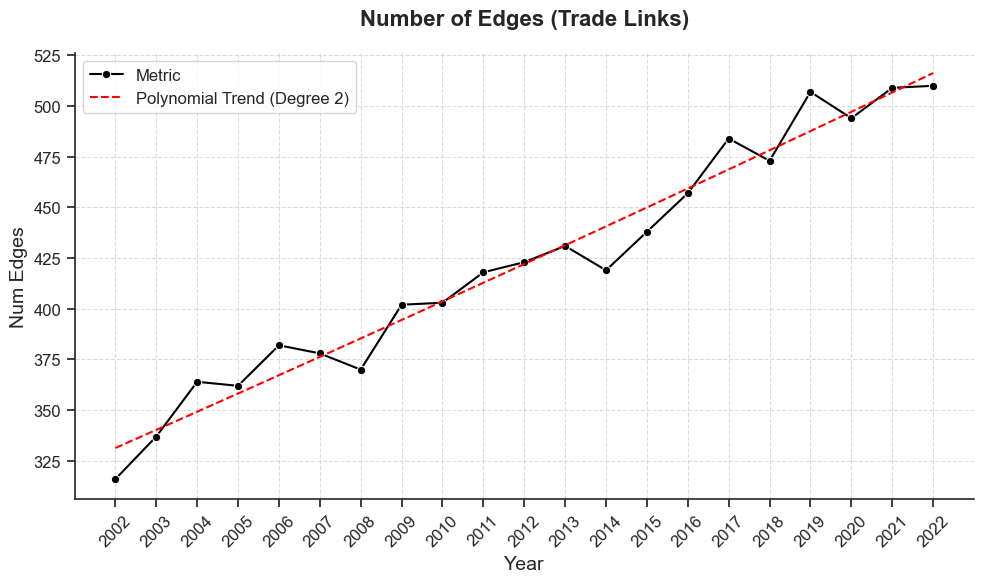

In [33]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_edges',
    title="Number of Edges (Trade Links)"
)

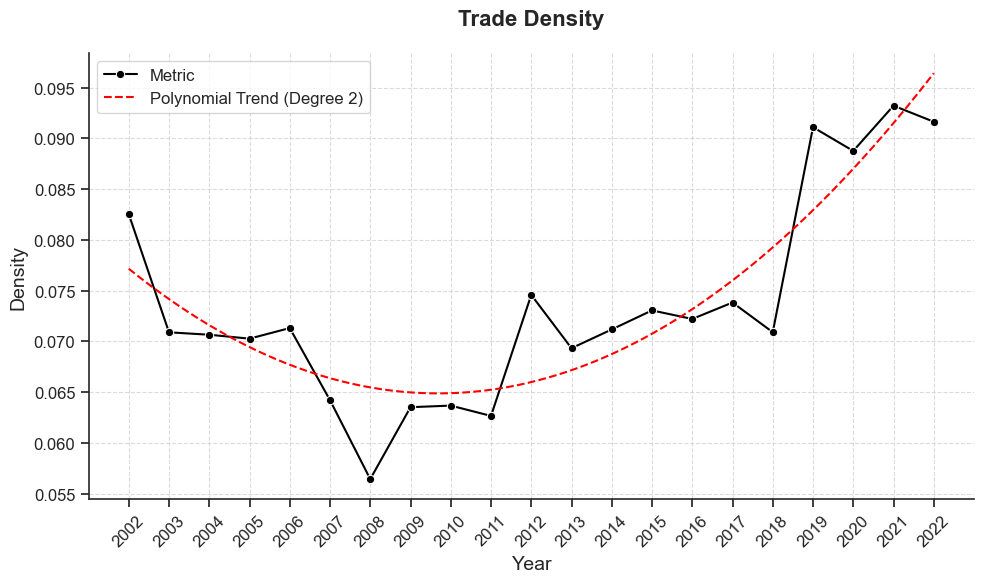

In [34]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='density',
    title="Trade Density"
)

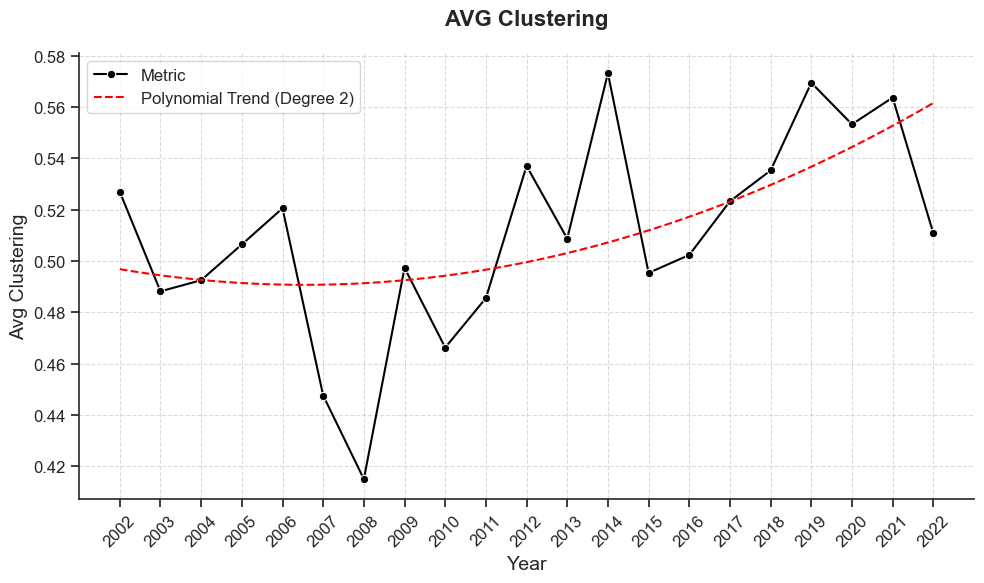

In [35]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_clustering',
    title="AVG Clustering"
)

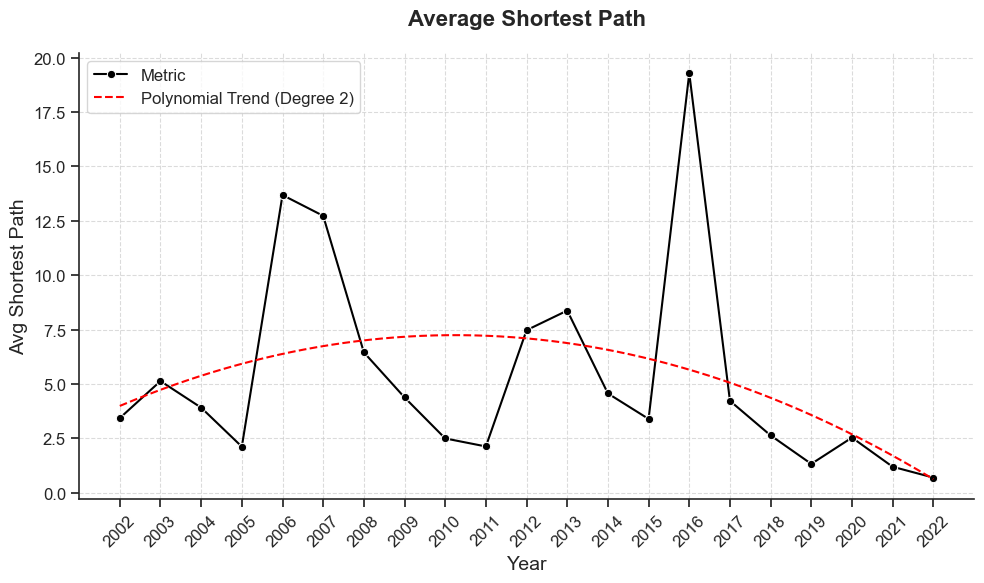

In [36]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_shortest_path',
    title="Average Shortest Path"
)

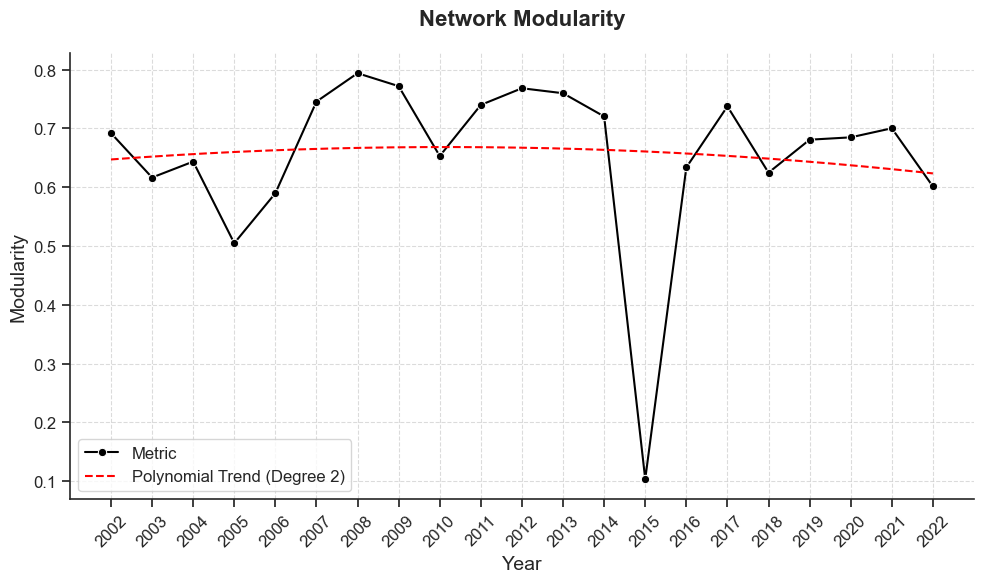

In [37]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='modularity',
    title="Network Modularity"
)

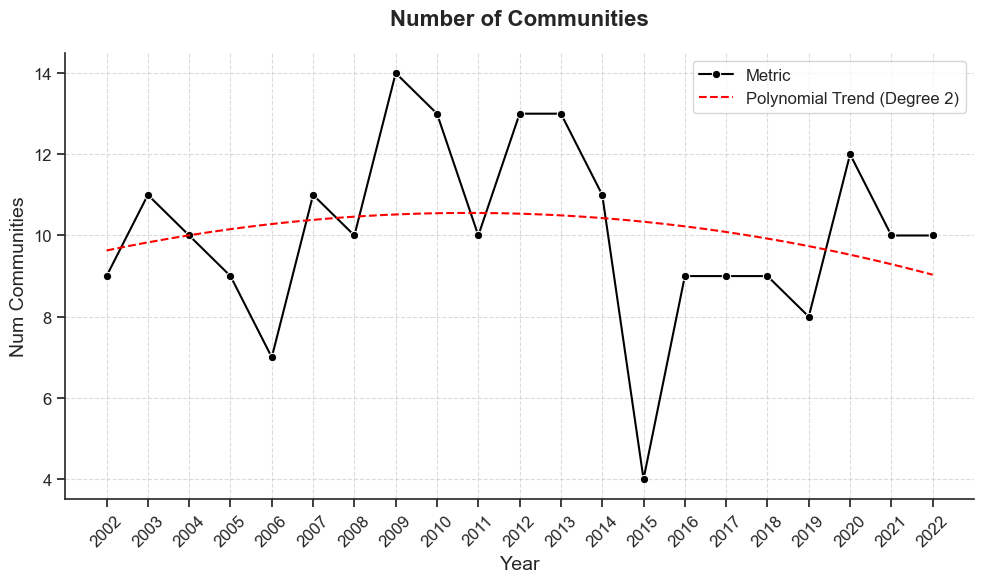

In [38]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_communities',
    title="Number of Communities"
)

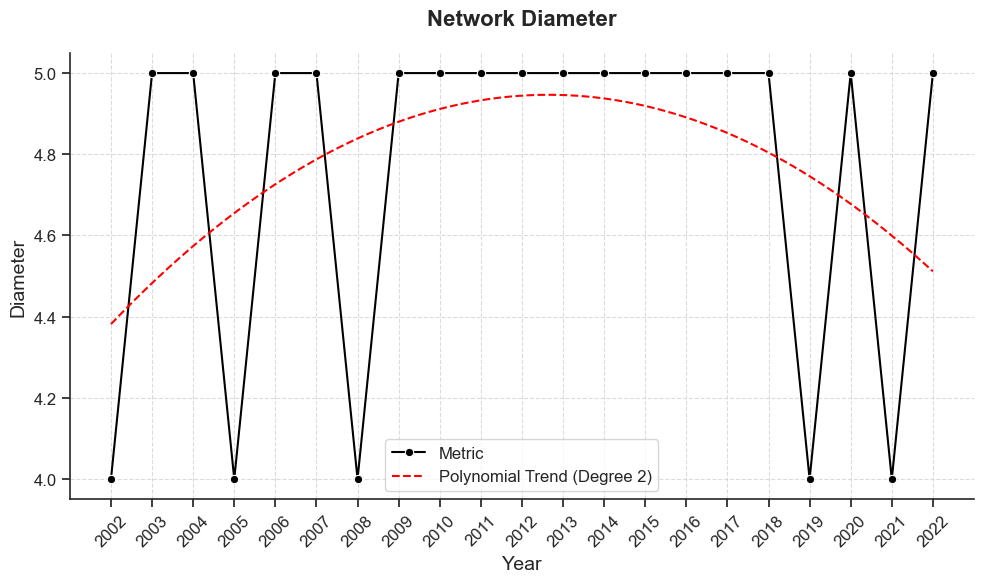

In [39]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='diameter',
    title="Network Diameter"
)

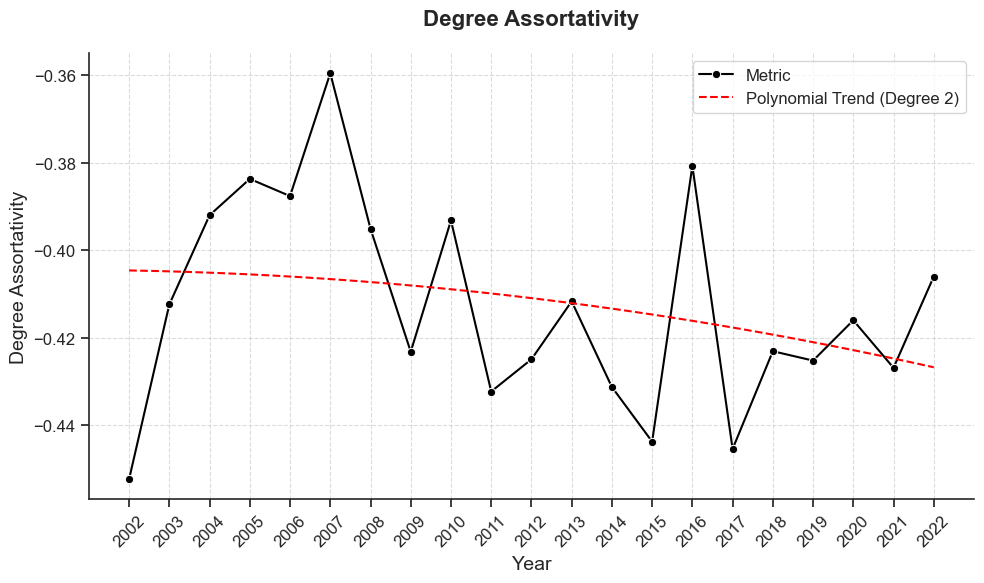

In [40]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='degree_assortativity',
    title="Degree Assortativity"
)

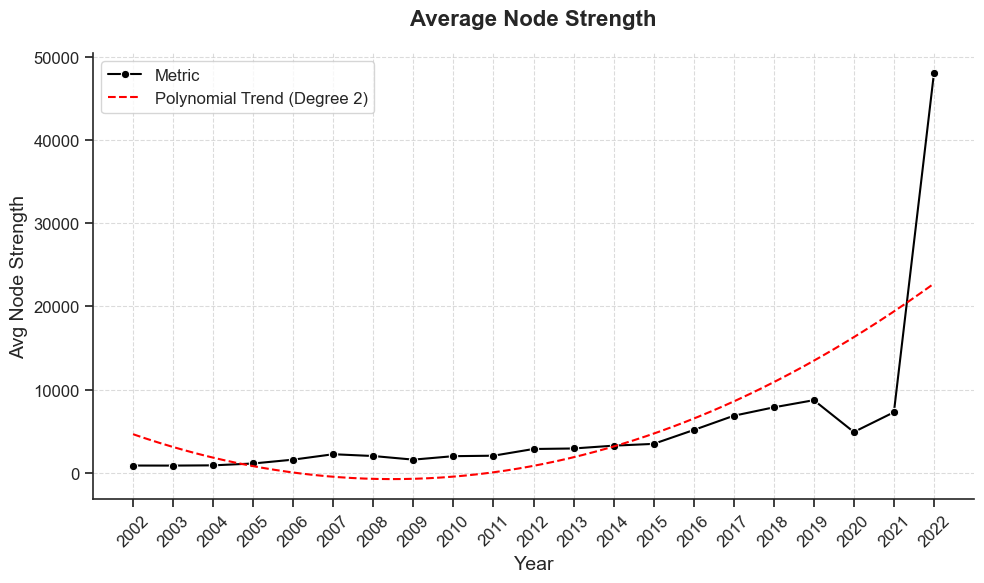

In [41]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_node_strength',
    title="Average Node Strength"
)

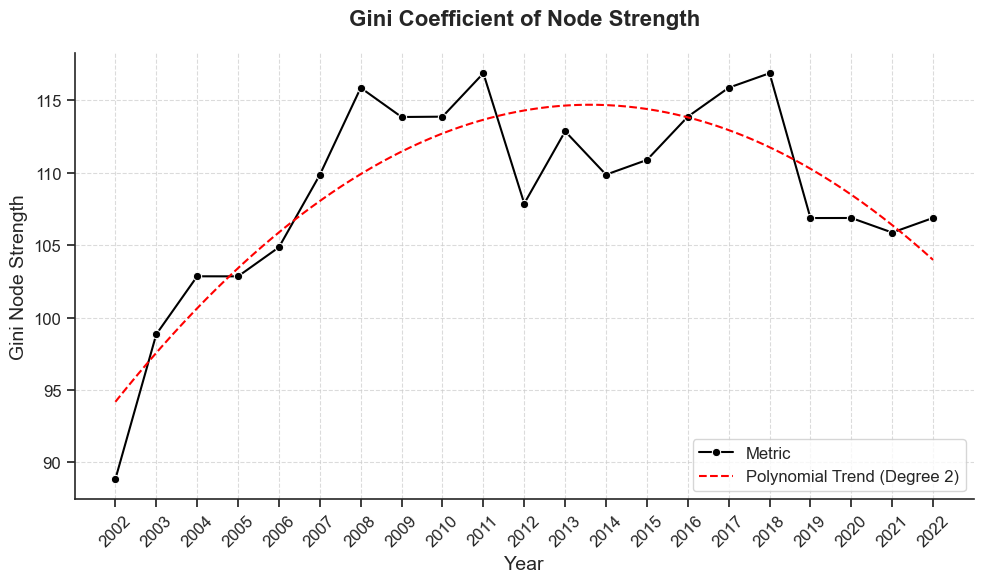

In [42]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='gini_node_strength',
    title="Gini Coefficient of Node Strength"
)

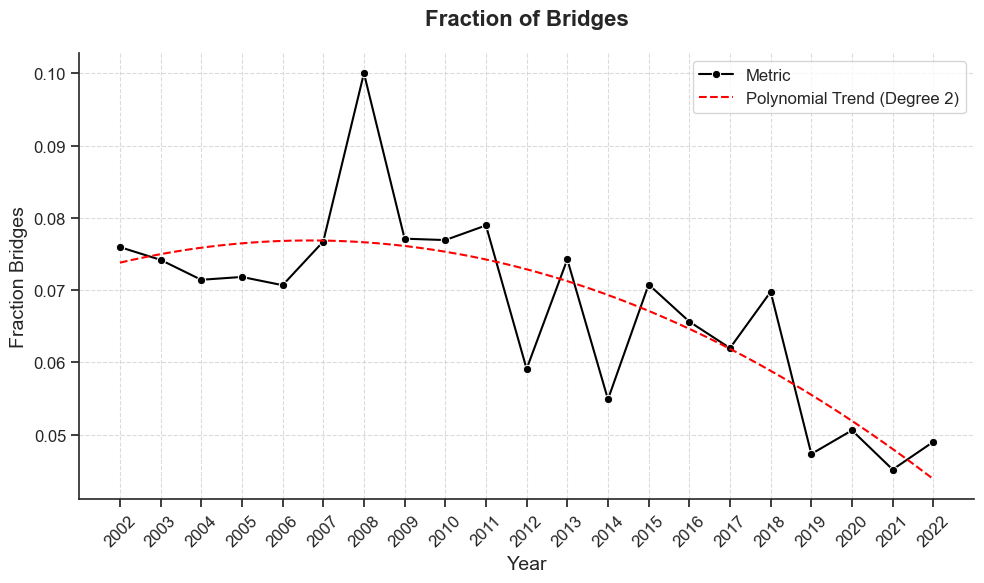

In [43]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='fraction_bridges',
    title="Fraction of Bridges"
)

### Macro Economic Metrics

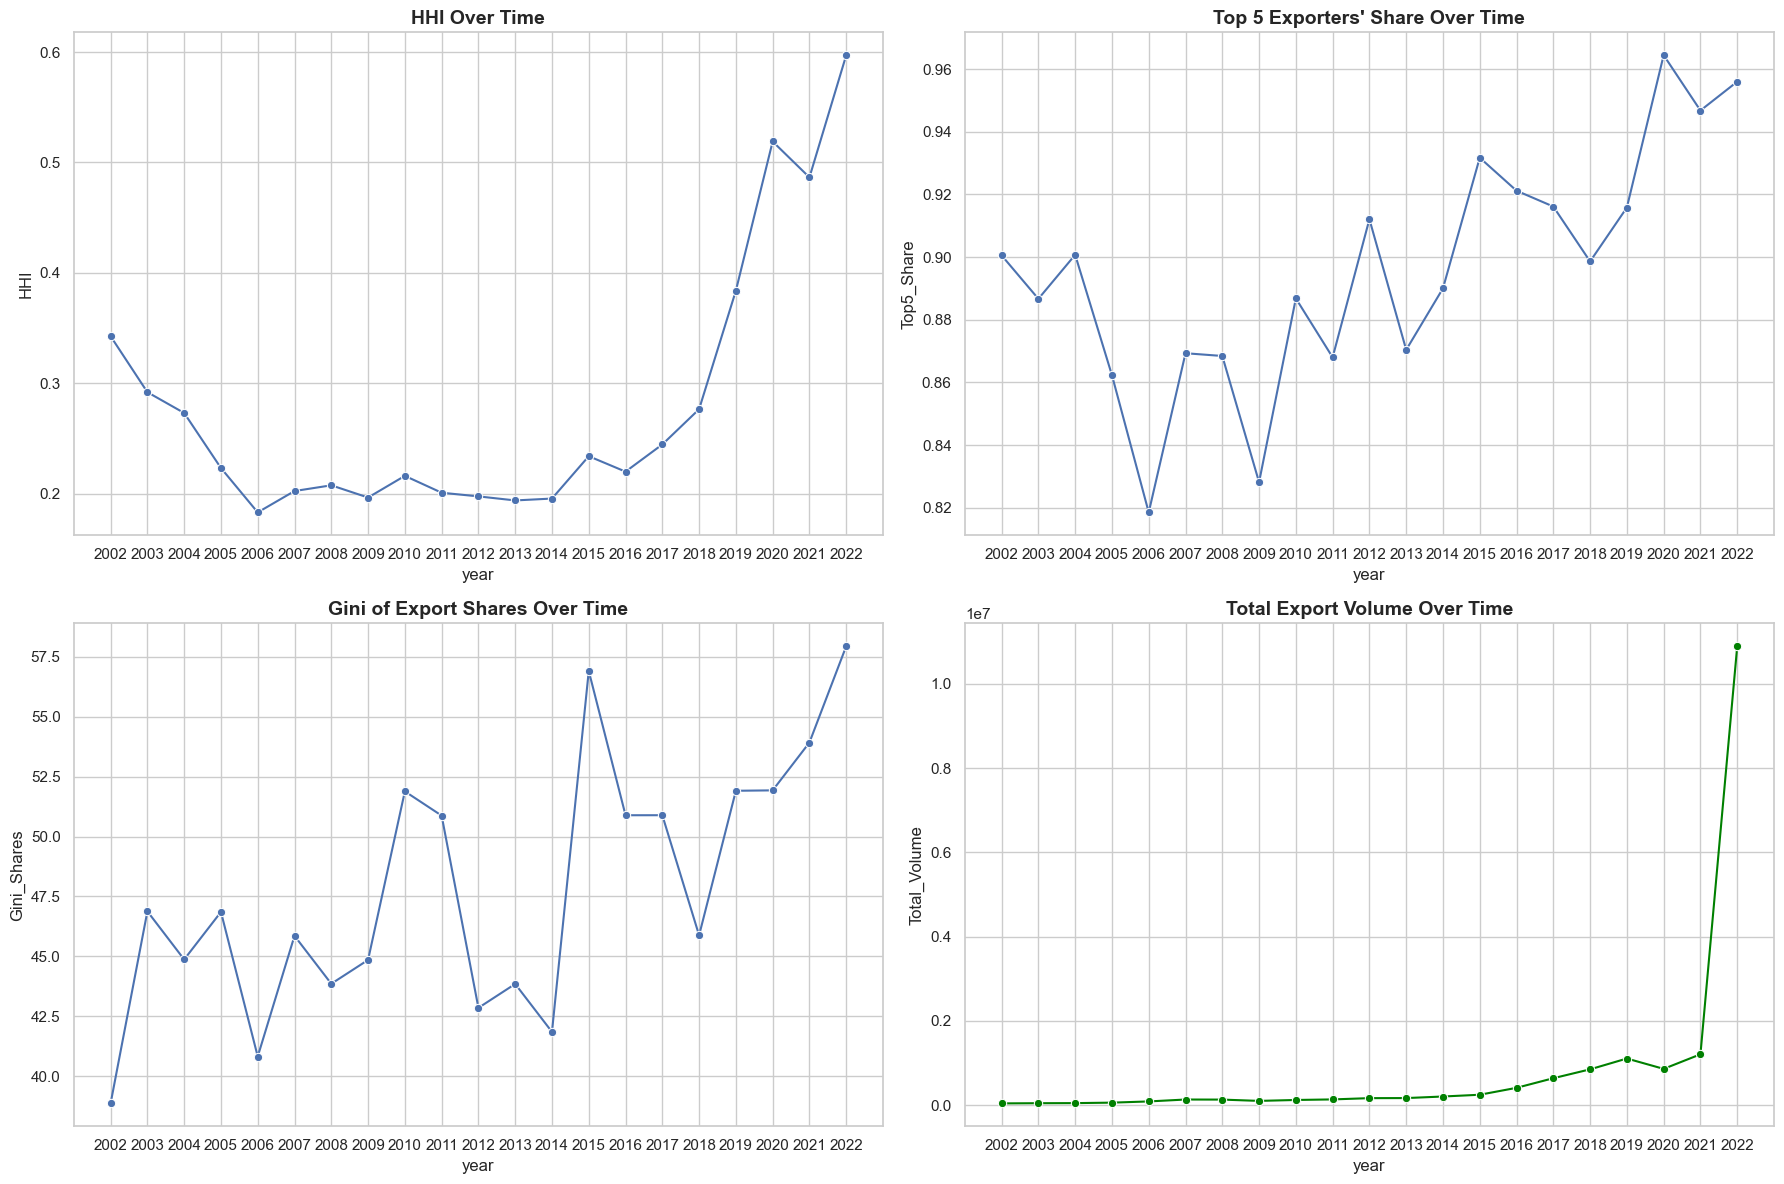

In [44]:
yearly_exports = (
    df.groupby(["t", "export_country"], as_index=False)["v"].sum()
)

years_list = []
hhi_list = []
top5_share_list = []
gini_list = []
shannon_list = []
total_volume_list = []

def gini_coefficient(arr):
    arr = np.array(arr)
    arr = arr[arr > 0]
    arr = np.sort(arr)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n+1 - 2*np.sum(rel_cumulative)/n)

for year, grp in yearly_exports.groupby("t"):
    total_exports = grp["v"].sum()
    shares = grp["v"] / total_exports

    # HHI (Herfindhal Hirschman Index)
    hhi = (shares ** 2).sum()

    # Top 5 Exporter Share
    sorted_shares = np.sort(shares)[::-1]
    top5 = sorted_shares[:5].sum() if len(sorted_shares)>=5 else sorted_shares.sum()

    # Gini Coefficient of Exporter Share
    gini_val = gini_coefficient(shares.values)

    years_list.append(year)
    hhi_list.append(hhi)
    top5_share_list.append(top5)
    gini_list.append(gini_val)
    total_volume_list.append(total_exports)

metrics_df = pd.DataFrame({
    "year": years_list,
    "HHI": hhi_list,
    "Top5_Share": top5_share_list,
    "Gini_Shares": gini_list,
    "Total_Volume": total_volume_list
})

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

sns.lineplot(data=metrics_df, x="year", y="HHI", marker="o", ax=axs[0])
axs[0].set_title("HHI Over Time", fontsize=14, fontweight='bold')
axs[0].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Top5_Share", marker="o", ax=axs[1])
axs[1].set_title("Top 5 Exporters' Share Over Time", fontsize=14, fontweight='bold')
axs[1].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Gini_Shares", marker="o", ax=axs[2])
axs[2].set_title("Gini of Export Shares Over Time", fontsize=14, fontweight='bold')
axs[2].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Total_Volume", marker="o", ax=axs[3], color='green')
axs[3].set_title("Total Export Volume Over Time", fontsize=14, fontweight='bold')
axs[3].set_xticks(metrics_df["year"].unique().astype(int))

plt.tight_layout()
plt.show()